In [24]:
# import modules
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

In [2]:
# global variables
SCALER = StandardScaler()
ROS = RandomOverSampler(random_state=42)

## Dataset

The data used in this example is from [MAGIC Gamma Telescope](http://archive.ics.uci.edu/dataset/159/magic+gamma+telescope) dataset hosted by the UC Irvine Machine Learning Repository. The data represent simulated registrations of high energy gamma particles in an atmospheric Cherenkov telescope.

Download the ZIP file and store files in `data` directory as `data/magic04.data` and `data/magic04.names`.

In [3]:
# get column names from data/magic04.names
# you may need to review the magic04.names file to ensure you are retrieving
# column names from the correct lines in the document
cols_file = open('data/magic04.names')
cols_content = cols_file.readlines()[81:93]
cols_regex = [re.search(r'\.(.*?):', var.strip()) for var in cols_content]
cols_names = [var.group(1).strip() for var in cols_regex if var]

# read data/magic04.data into a pandas dataframe using cols_names as column names
df = pd.read_csv('data/magic04.data', names=cols_names)

# convert class to integer binary
# 1 = g, 0 = h (g is gamma, h is hadron)
df['class'] = (df['class'] == 'g').astype(int)

## Train, validation, and test datasets

In [4]:
# use numpy and sample to create splits for training, validation, and testing
train, valid, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [5]:
# we want to scale column values to have mean 0 and standard deviation 1
def scale_data(dataframe, oversample=False):
    """
    :param dataframe: pandas dataframe
    """
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    # use fit_transform to fit standard scaler to X and transform values
    X = SCALER.fit_transform(X)

    # if oversample is True, take more of the minotiry class and keep sampling
    # to increase size of minority class until it is relatively equal to the majority class
    if oversample:
        X, y = ROS.fit_resample(X, y)

    # create whole data as 2d numpy array
    # hstack stacks arrays in sequence horizontally (column wise)
    # need to reshape y into a 2d item using reshape
    # (-1, 1) means the array will be 1 column with the length of y
    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [6]:
# we want to oversample our training dataset to balance the number of gamma and hadron
# use the scale_data method to do this by passing in oversample = True
train, X_train, y_train = scale_data(train, oversample=True)

# use oversample = False for validation and test
# reason is that validation and test sets are for the purpose of evaluating the model
# using data that hasn't been seen by the model yet
valid, X_valid, y_valid = scale_data(valid)
test, X_test, y_test = scale_data(test)

## Neural Networks

A neural network is a method that teaches computers to process data in a way that is inspired by the human brain. This deep learning process uses interconnected nodes, or neurons, in a layered structure. This structure creates an adaptive system that computers can leverage to learn from mistakes and continuously improve.

Artificial neural networks (ANNs) are compromised of node layers, containing an input and an output layer, one or more hidden layers, and an output layer. Each node connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

See [documentation from IBM](https://www.ibm.com/topics/neural-networks) to learn more about neural networks.

### Tensorflow

Tensorflow makes it easy to define models when using neural networks but allows for defined input control. Take this model, for example:

```
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='reul'),
    tf.keras.layers.Dense(1)
])
```

Above, we defined a [Sequential](https://keras.io/guides/sequential_model/) model, which groups a linear stack of layers where each layer has exactly one input tensor and one output tensor. [Dense](https://keras.io/api/layers/core_layers/dense/) referes to the layers being interconnected, or the regular deeply connected neural network layer.

In [10]:
# need to define the input shape for first layer
# using sigmoid activation for output layer because this will project
# predictions to be binary (0 or 1), such that we can round to 0 or 1
# and classify prediction labels in this manner
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# need to make sure to compile when using tf
# can pass in an optimizer of your choice
# use the default learning rate of 0.001 and
# loss of binary_crossentropy
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [11]:
# to view measurements for assessing the model
# we use the following plot function
def plot_history(history):
    """
    Method for plotting loss and accuracy metrics
    :param history: model history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.show()

Tensorflow will keep track of the history of the training. We can supply several arguments to the [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method:
1. `epochs` represent the number of iterations over the input dataset. A model is updated each time a batch is processed, such that it can be updated multiple times in a given epoch. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.
2. `batch_size` defines the number of samples propagated through the network. This represents the number of samples to work through before updating the internal model parameters. You can read more about epochs and batches [here](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/).
3. `validation_split` is the fraction of training data to be used as validation data. If this argument is set to 0.2, this means that we leave 20 percent out and test how the model performs on that data during the training steps.
4. `verbose` being set to 0 will avoid length print statements from the model training process.

In [13]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.02,
    verbose=0
)

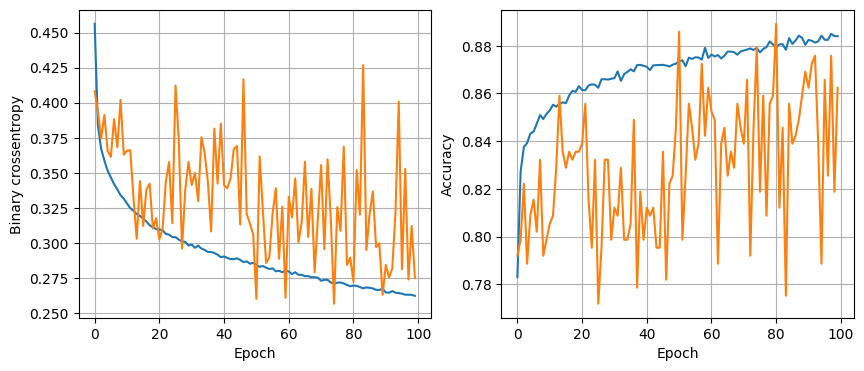

In [14]:
# plot history to see metrics
plot_history(history)

We observe a steadily decreasing loss and an increasing accuracy. We might want to see how these metrics perform for different inputs. So, we can functionalize our model generation process to observe how different hyperparameters impact the performance of the model. With this method, we can use a [grid search](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e) to search through an entire space to test different combinations of input hyperparameters.

For this next step, we will also add a [Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/). This layer randomly sets input units to 0 with a frequency of rate at each step during training time. This helps prevent overfitting. Input not set to 0 are scaled to 1/(1 - rate) such that the sum over all inputs is unchanged. Essentially, Dropout selects random nodes at a certain rate and does not train them in a given iteration.

In [16]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
    """
    :param X_train: input training data
    :param y_train: predicted training data values
    :param num_nodes: number of nodes in layer
    :param dropout_prob: rate for dropout layer
    :param lr: learning rate for optimizer
    :param batch_size:
    :param epochs:
    :return: model and model history
    """
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                    metrics=['accuracy'])
    history = nn_model.fit(
      X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
    )

    return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


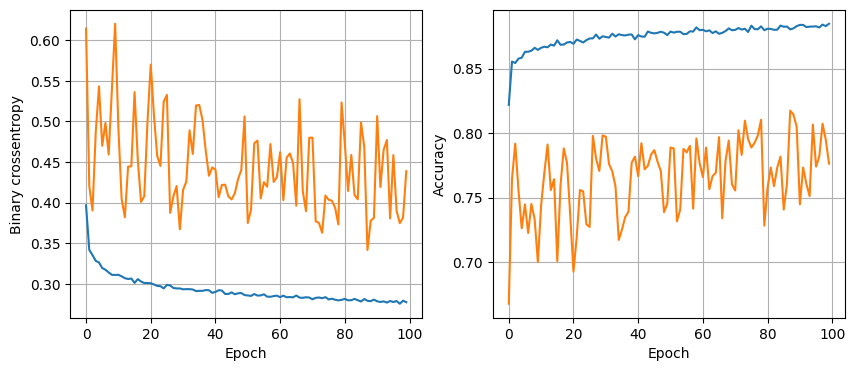

119/119 [==============================] - 0s 2ms/step - loss: 0.3295 - accuracy: 0.8686
16 nodes, dropout 0, lr 0.01, batch size 64


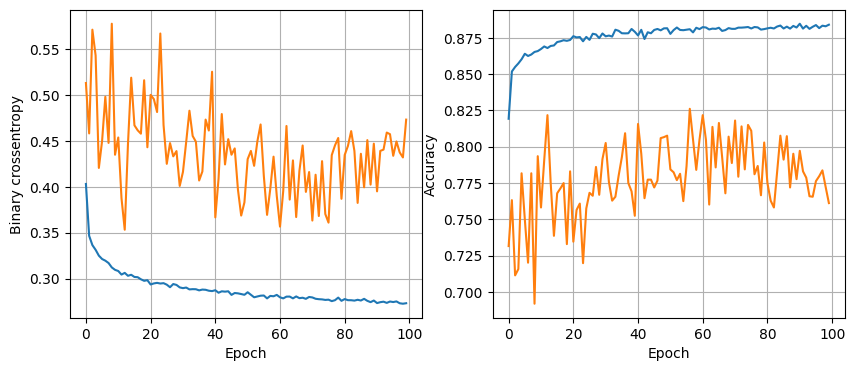

119/119 [==============================] - 0s 2ms/step - loss: 0.3230 - accuracy: 0.8686
16 nodes, dropout 0, lr 0.01, batch size 128


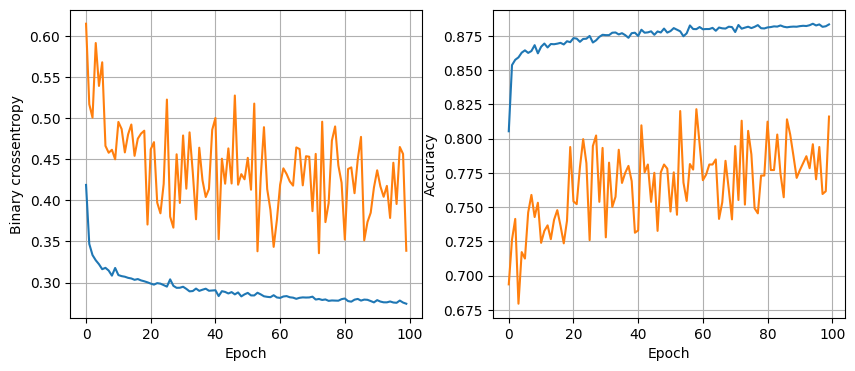

119/119 [==============================] - 0s 2ms/step - loss: 0.3239 - accuracy: 0.8704
16 nodes, dropout 0, lr 0.005, batch size 32


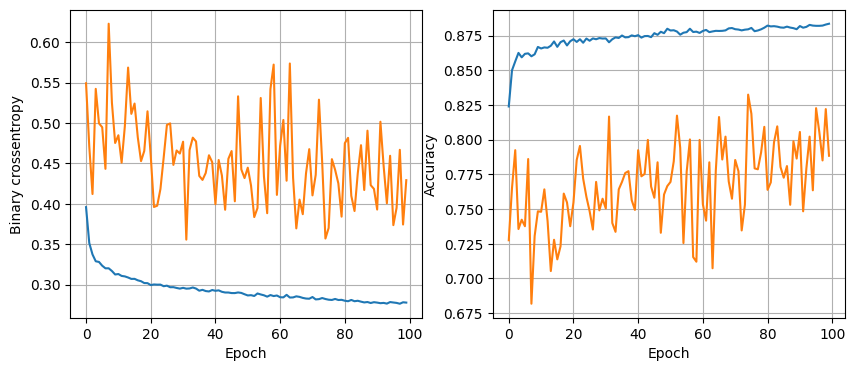

119/119 [==============================] - 0s 2ms/step - loss: 0.3272 - accuracy: 0.8707
16 nodes, dropout 0, lr 0.005, batch size 64


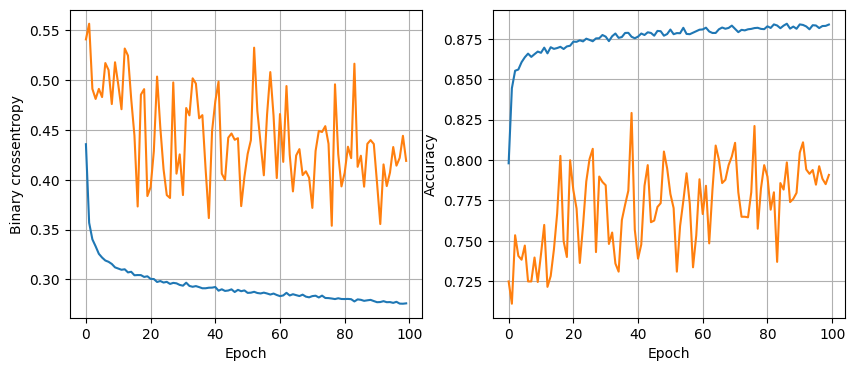

119/119 [==============================] - 0s 2ms/step - loss: 0.3146 - accuracy: 0.8733
16 nodes, dropout 0, lr 0.005, batch size 128


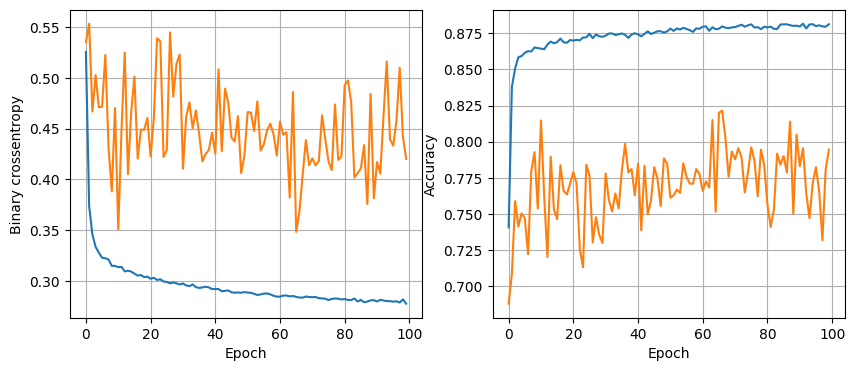

119/119 [==============================] - 0s 2ms/step - loss: 0.3168 - accuracy: 0.8715
16 nodes, dropout 0, lr 0.001, batch size 32


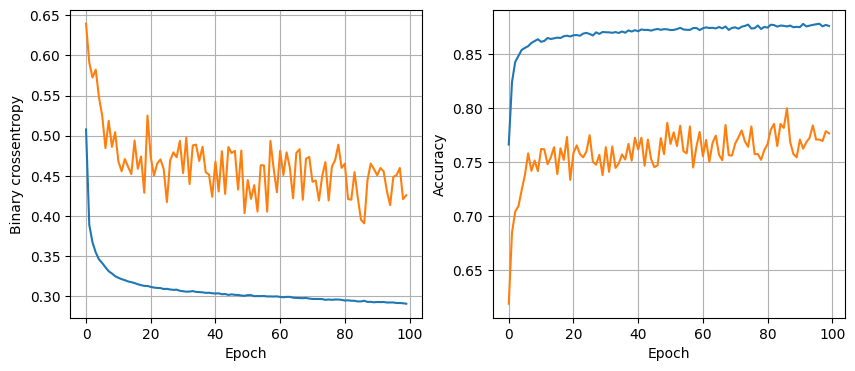

119/119 [==============================] - 0s 2ms/step - loss: 0.3165 - accuracy: 0.8691
16 nodes, dropout 0, lr 0.001, batch size 64


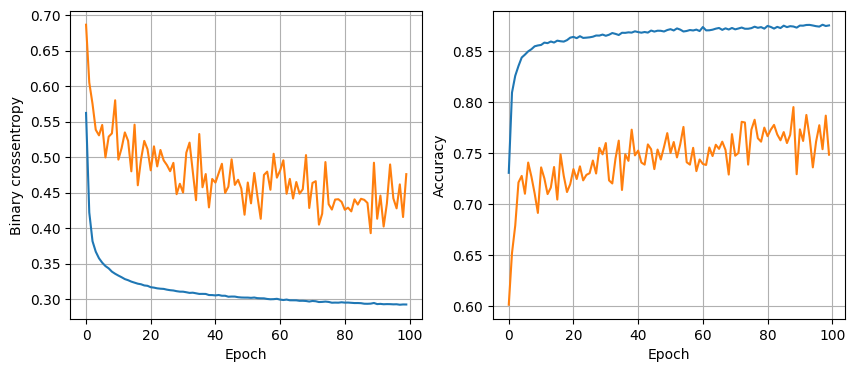

119/119 [==============================] - 0s 3ms/step - loss: 0.3151 - accuracy: 0.8728
16 nodes, dropout 0, lr 0.001, batch size 128


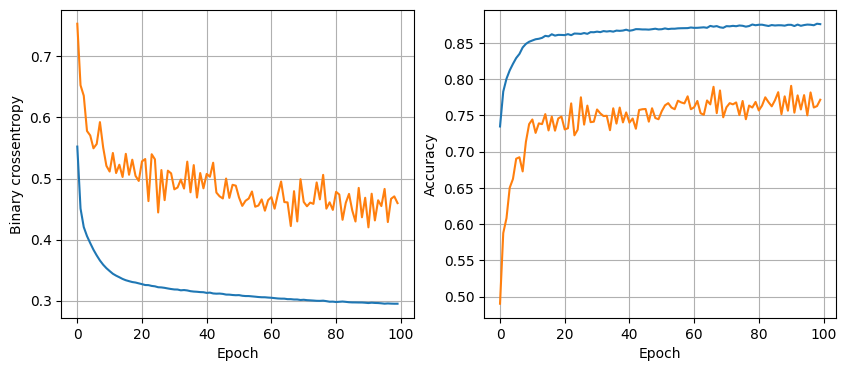

119/119 [==============================] - 0s 3ms/step - loss: 0.3129 - accuracy: 0.8707
16 nodes, dropout 0.2, lr 0.01, batch size 32


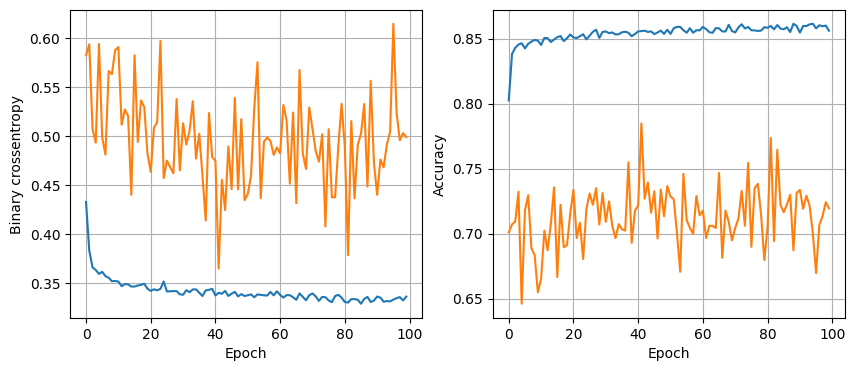

119/119 [==============================] - 0s 2ms/step - loss: 0.3301 - accuracy: 0.8712
16 nodes, dropout 0.2, lr 0.01, batch size 64


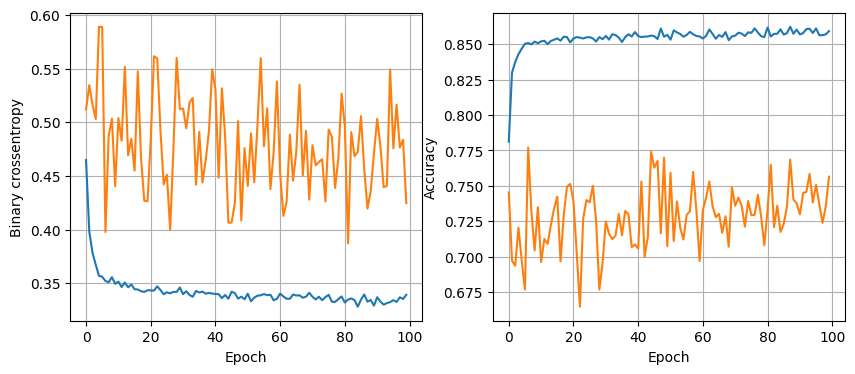

119/119 [==============================] - 0s 2ms/step - loss: 0.3207 - accuracy: 0.8730
16 nodes, dropout 0.2, lr 0.01, batch size 128


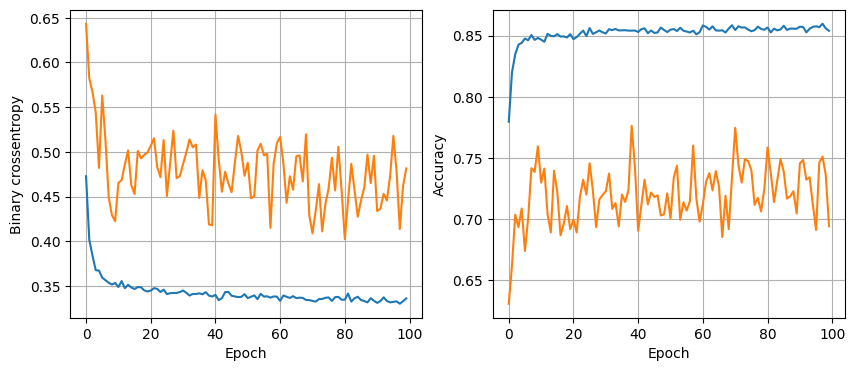

119/119 [==============================] - 0s 2ms/step - loss: 0.3292 - accuracy: 0.8688
16 nodes, dropout 0.2, lr 0.005, batch size 32


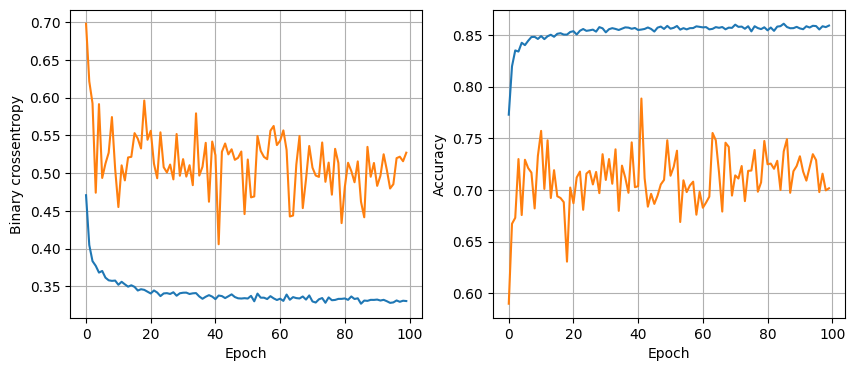

119/119 [==============================] - 0s 2ms/step - loss: 0.3195 - accuracy: 0.8667
16 nodes, dropout 0.2, lr 0.005, batch size 64


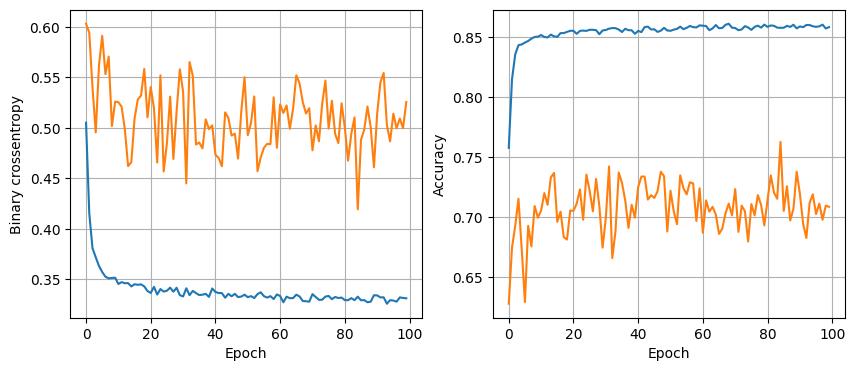

119/119 [==============================] - 0s 2ms/step - loss: 0.3208 - accuracy: 0.8675
16 nodes, dropout 0.2, lr 0.005, batch size 128


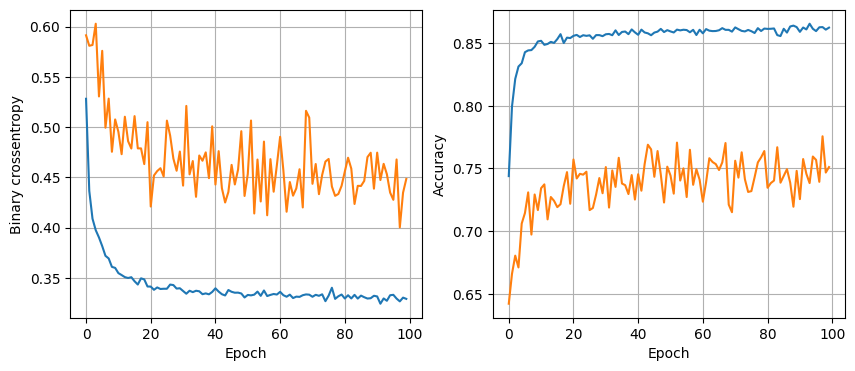

119/119 [==============================] - 0s 2ms/step - loss: 0.3194 - accuracy: 0.8736
16 nodes, dropout 0.2, lr 0.001, batch size 32


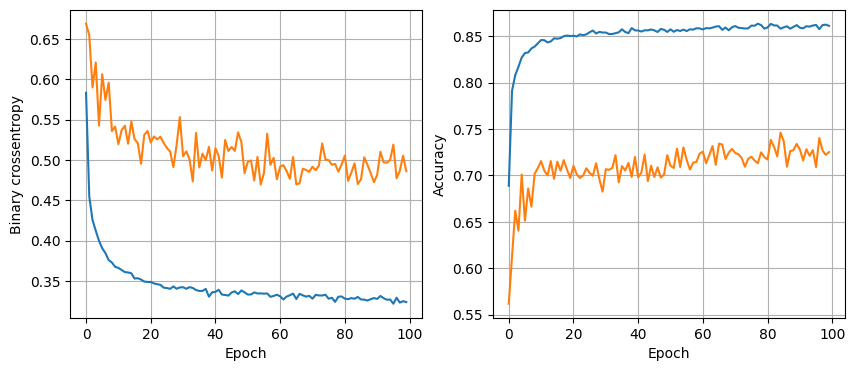

119/119 [==============================] - 0s 2ms/step - loss: 0.3186 - accuracy: 0.8683
16 nodes, dropout 0.2, lr 0.001, batch size 64


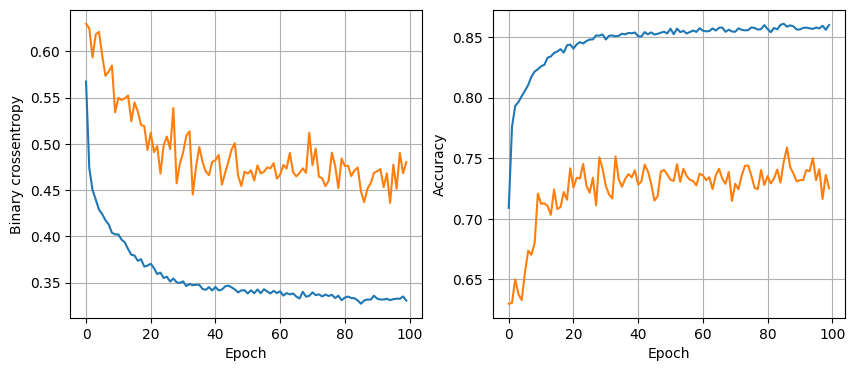

119/119 [==============================] - 0s 3ms/step - loss: 0.3212 - accuracy: 0.8680
16 nodes, dropout 0.2, lr 0.001, batch size 128


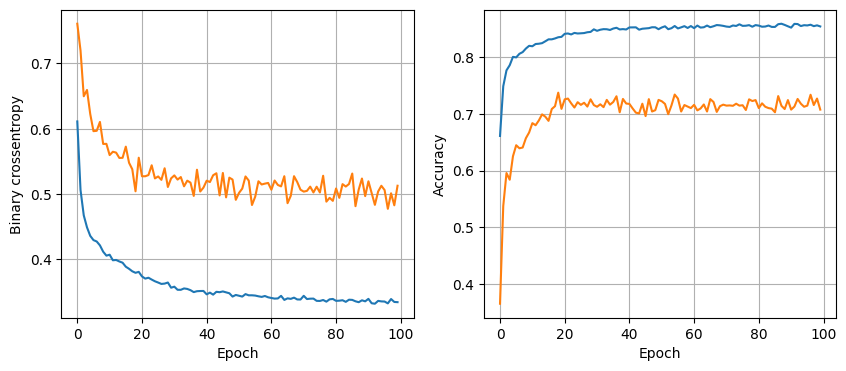

119/119 [==============================] - 0s 2ms/step - loss: 0.3214 - accuracy: 0.8680
32 nodes, dropout 0, lr 0.01, batch size 32


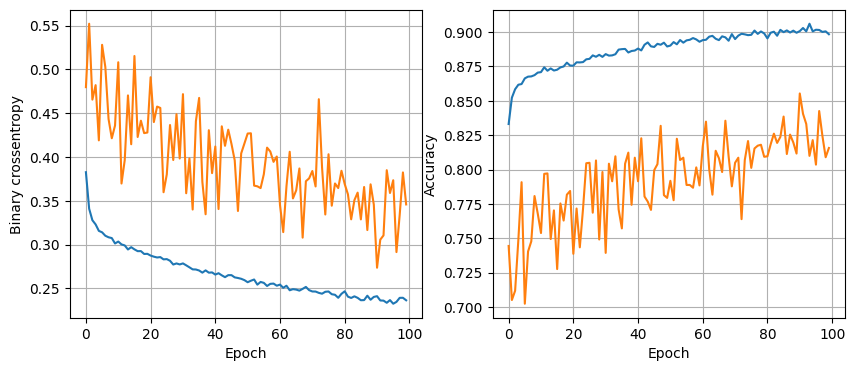

119/119 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8641
32 nodes, dropout 0, lr 0.01, batch size 64


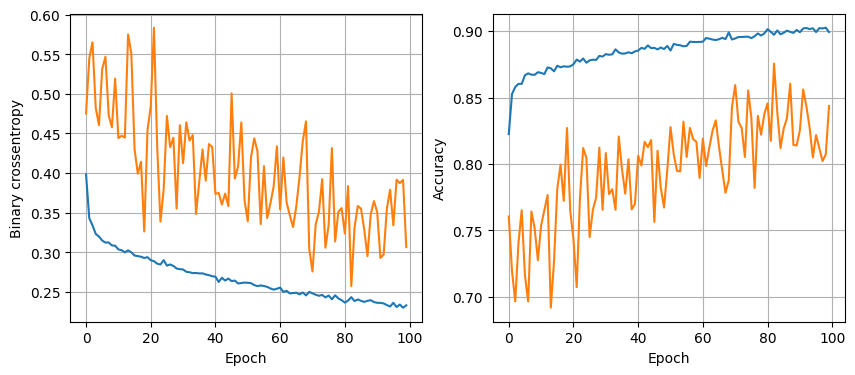

119/119 [==============================] - 0s 2ms/step - loss: 0.3938 - accuracy: 0.8612
32 nodes, dropout 0, lr 0.01, batch size 128


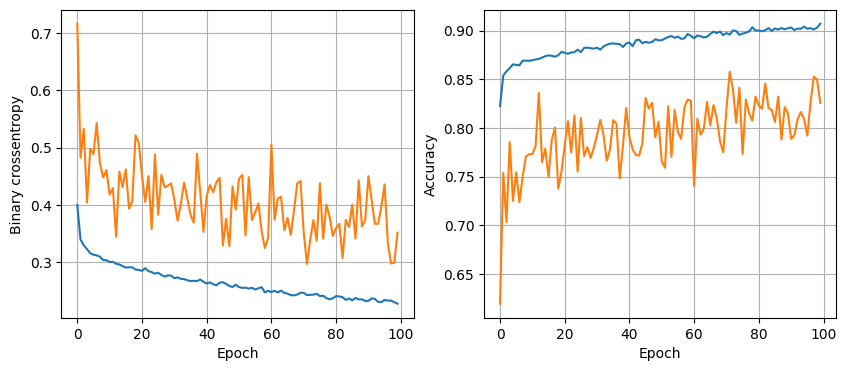

119/119 [==============================] - 0s 2ms/step - loss: 0.3887 - accuracy: 0.8659
32 nodes, dropout 0, lr 0.005, batch size 32


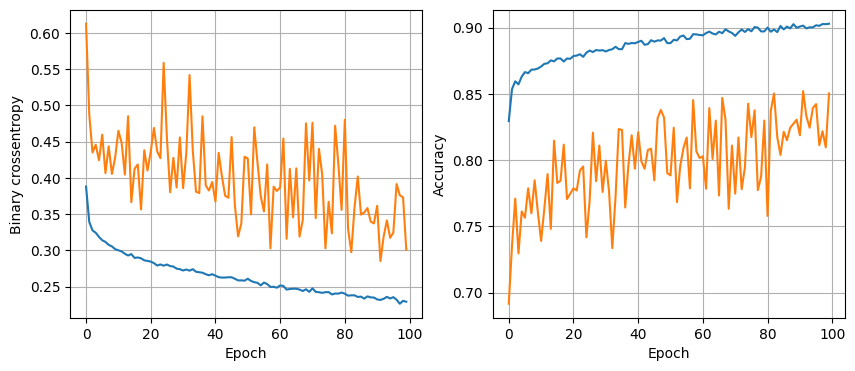

119/119 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8544
32 nodes, dropout 0, lr 0.005, batch size 64


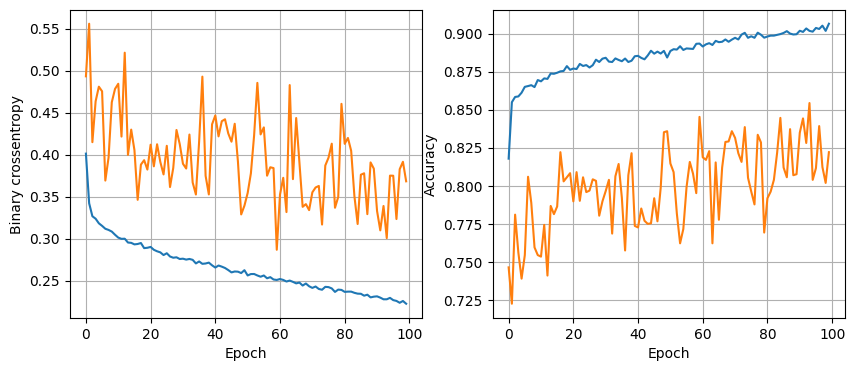

119/119 [==============================] - 0s 2ms/step - loss: 0.3551 - accuracy: 0.8707
32 nodes, dropout 0, lr 0.005, batch size 128


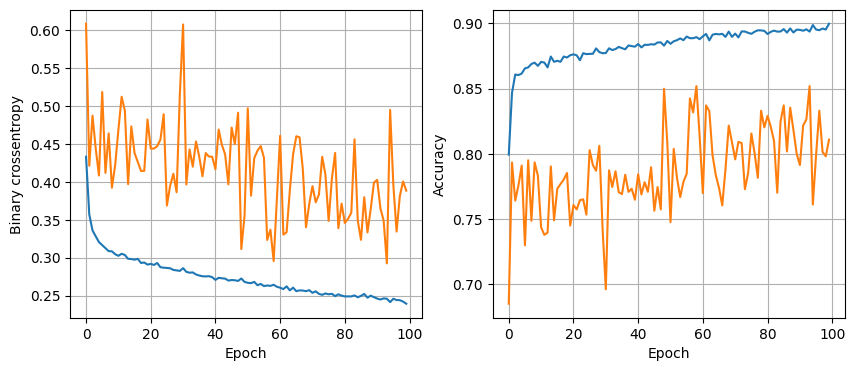

119/119 [==============================] - 0s 2ms/step - loss: 0.3456 - accuracy: 0.8680
32 nodes, dropout 0, lr 0.001, batch size 32


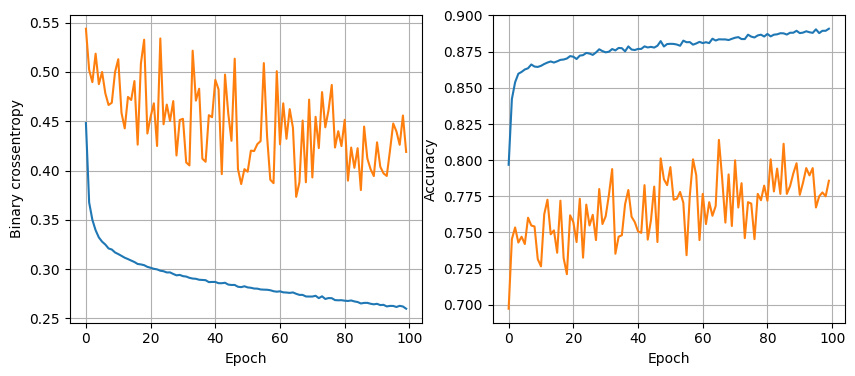

119/119 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8686
32 nodes, dropout 0, lr 0.001, batch size 64


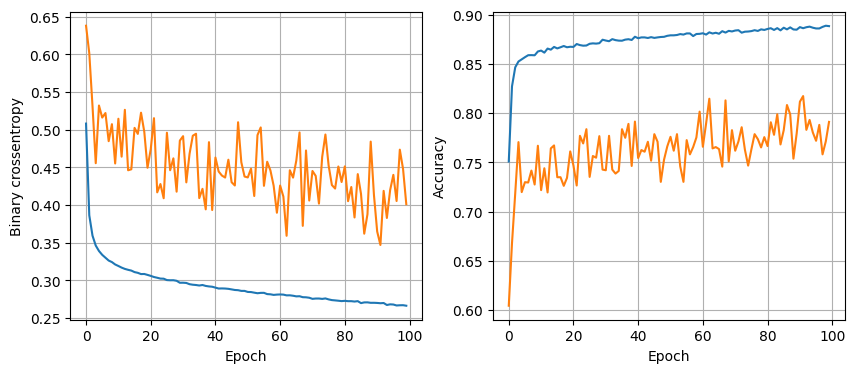

119/119 [==============================] - 0s 3ms/step - loss: 0.3121 - accuracy: 0.8699
32 nodes, dropout 0, lr 0.001, batch size 128


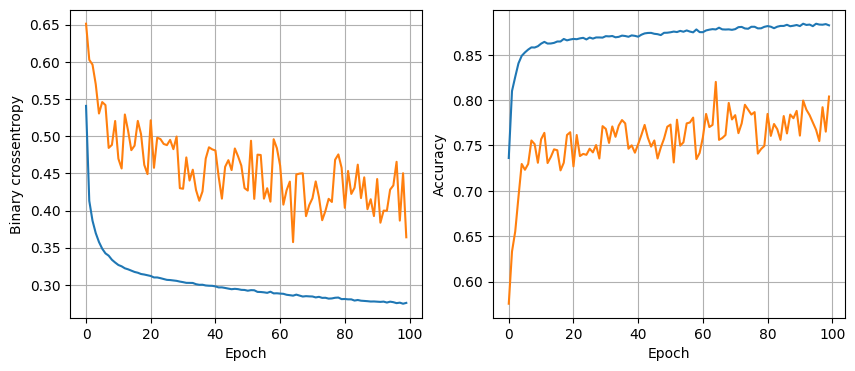

119/119 [==============================] - 0s 2ms/step - loss: 0.3166 - accuracy: 0.8675
32 nodes, dropout 0.2, lr 0.01, batch size 32


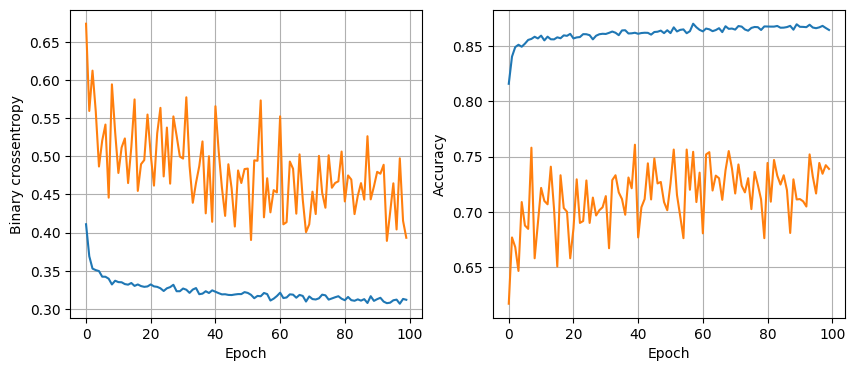

119/119 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8759
32 nodes, dropout 0.2, lr 0.01, batch size 64


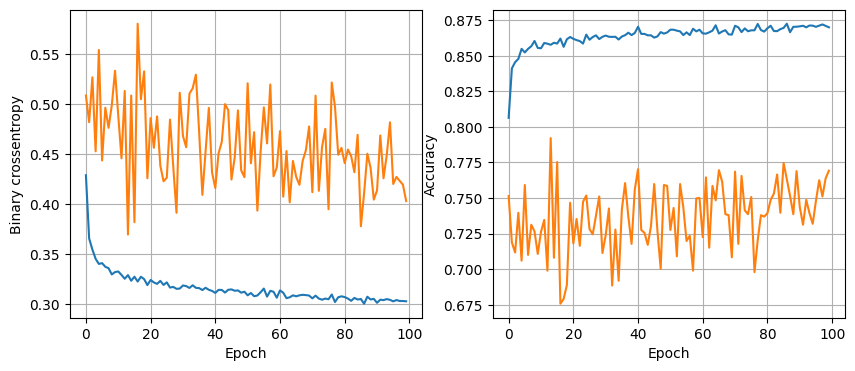

119/119 [==============================] - 0s 3ms/step - loss: 0.3063 - accuracy: 0.8767
32 nodes, dropout 0.2, lr 0.01, batch size 128


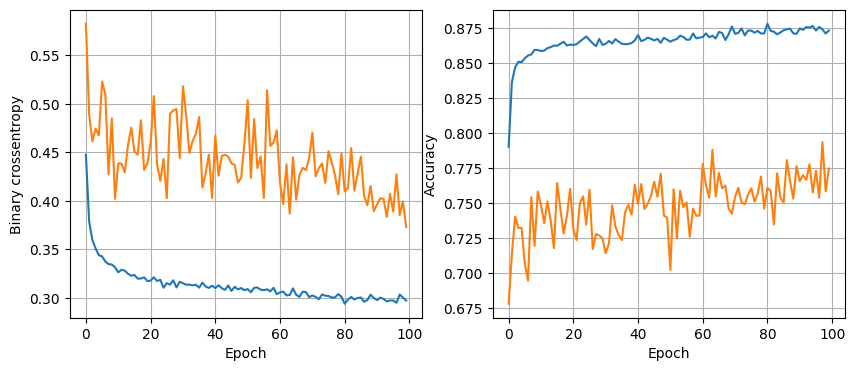

119/119 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.8825
32 nodes, dropout 0.2, lr 0.005, batch size 32


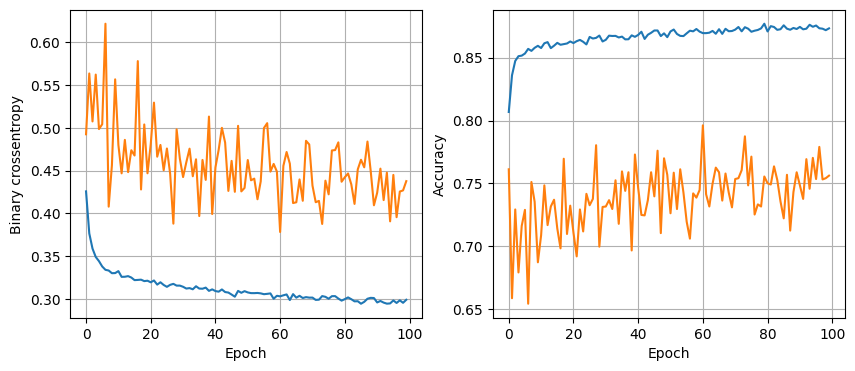

119/119 [==============================] - 0s 2ms/step - loss: 0.3050 - accuracy: 0.8770
32 nodes, dropout 0.2, lr 0.005, batch size 64


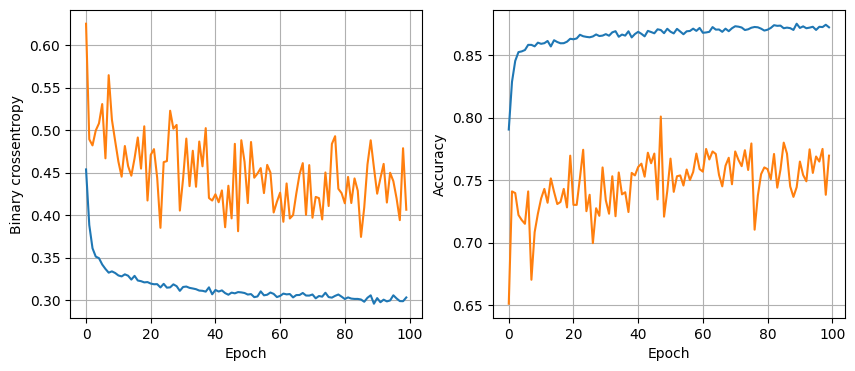

119/119 [==============================] - 0s 3ms/step - loss: 0.3069 - accuracy: 0.8785
32 nodes, dropout 0.2, lr 0.005, batch size 128


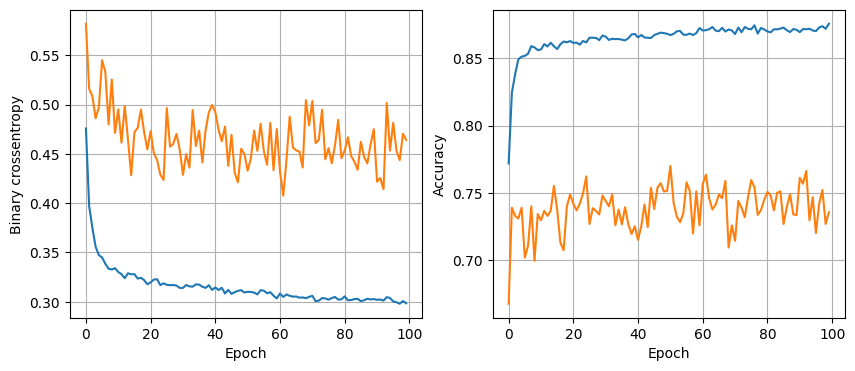

119/119 [==============================] - 0s 2ms/step - loss: 0.3079 - accuracy: 0.8736
32 nodes, dropout 0.2, lr 0.001, batch size 32


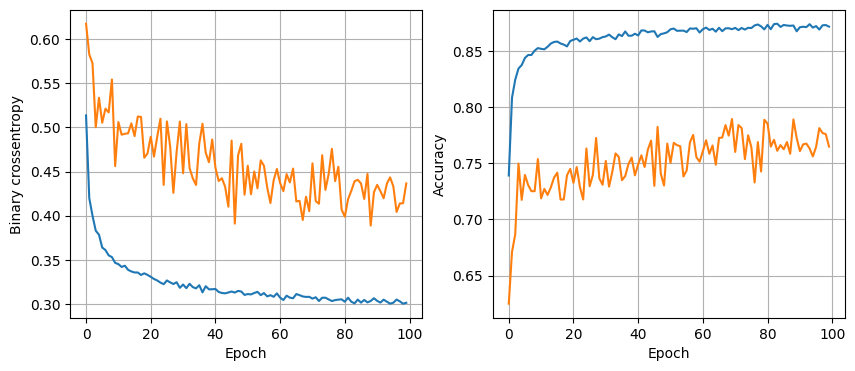

119/119 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.8767
32 nodes, dropout 0.2, lr 0.001, batch size 64


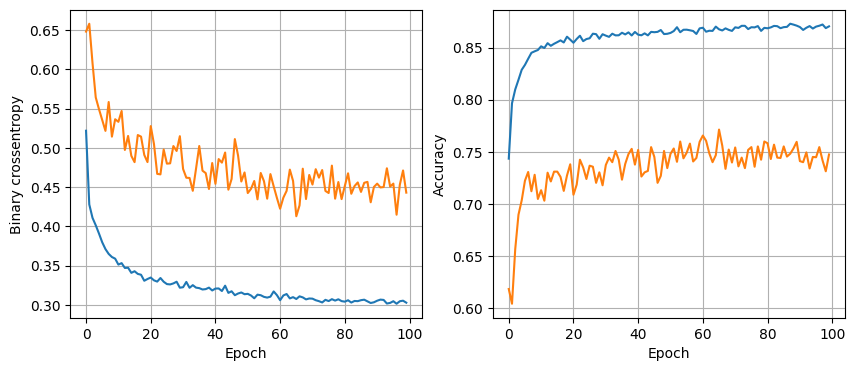

119/119 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8783
32 nodes, dropout 0.2, lr 0.001, batch size 128


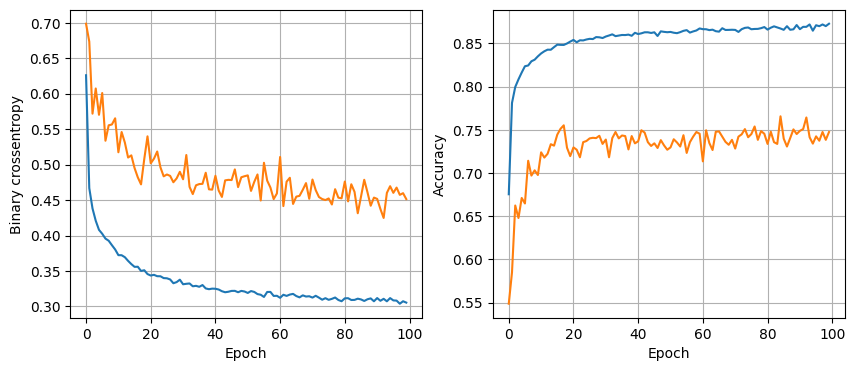

119/119 [==============================] - 0s 2ms/step - loss: 0.3086 - accuracy: 0.8759
64 nodes, dropout 0, lr 0.01, batch size 32


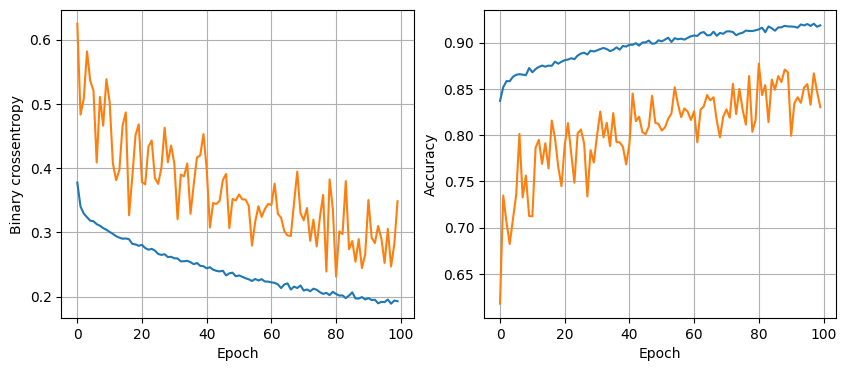

119/119 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.8596
64 nodes, dropout 0, lr 0.01, batch size 64


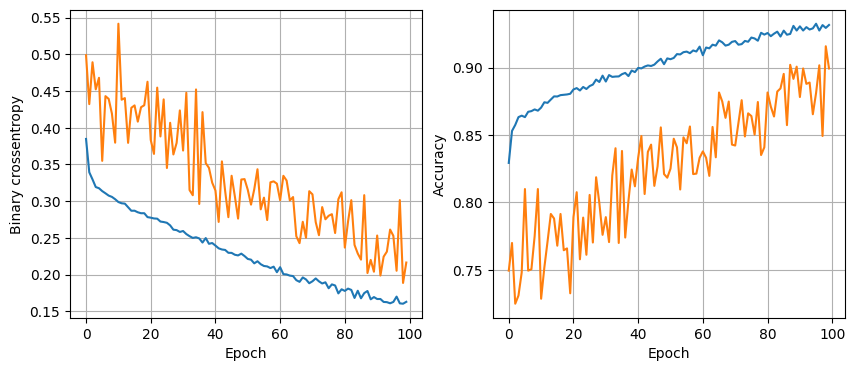

119/119 [==============================] - 1s 4ms/step - loss: 0.5570 - accuracy: 0.8565
64 nodes, dropout 0, lr 0.01, batch size 128


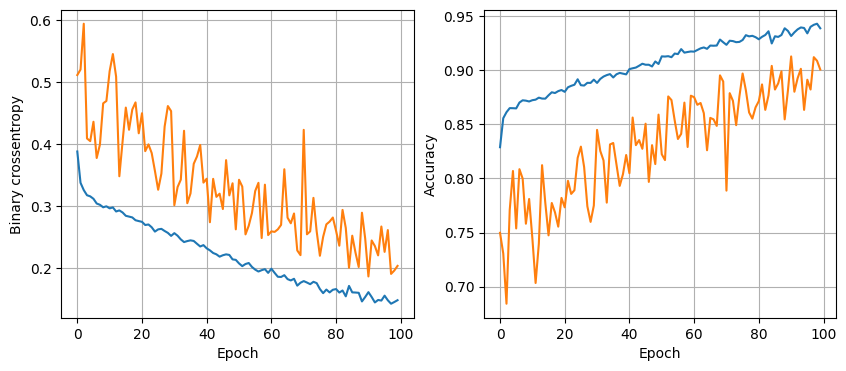

119/119 [==============================] - 0s 2ms/step - loss: 0.5635 - accuracy: 0.8591
64 nodes, dropout 0, lr 0.005, batch size 32


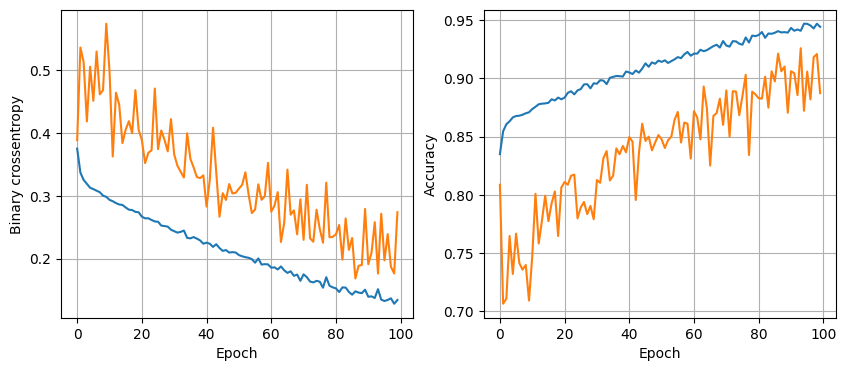

119/119 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.8620
64 nodes, dropout 0, lr 0.005, batch size 64


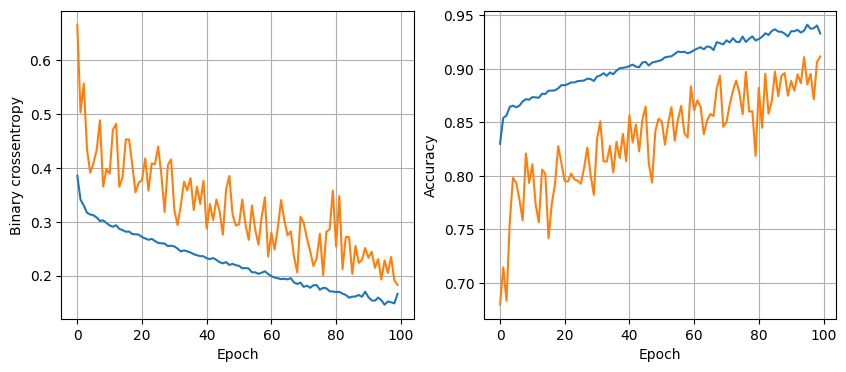

119/119 [==============================] - 0s 2ms/step - loss: 0.5016 - accuracy: 0.8515
64 nodes, dropout 0, lr 0.005, batch size 128


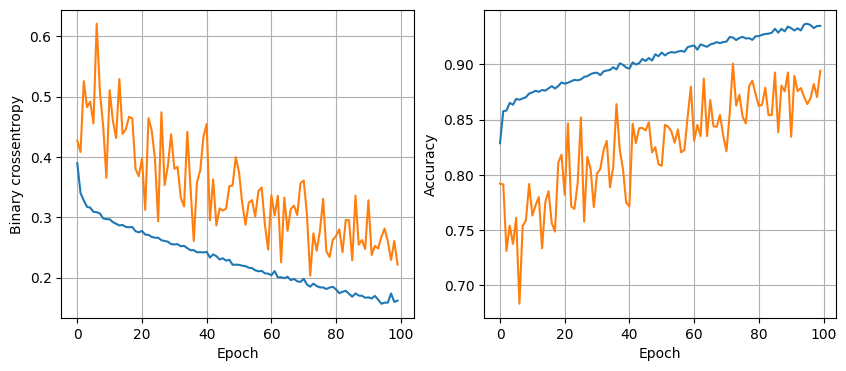

119/119 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.8607
64 nodes, dropout 0, lr 0.001, batch size 32


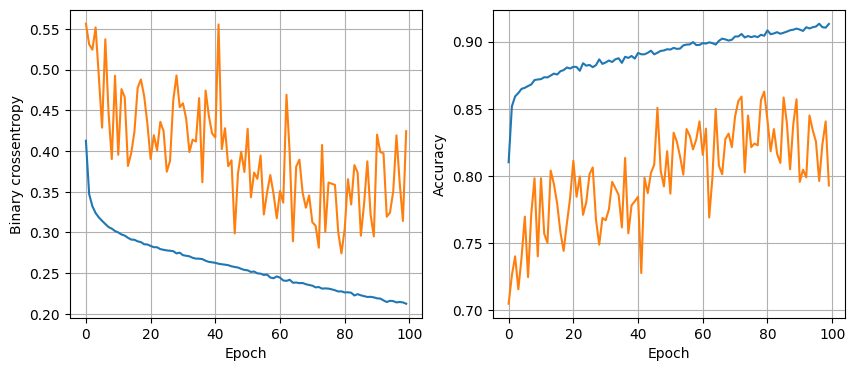

119/119 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8675
64 nodes, dropout 0, lr 0.001, batch size 64


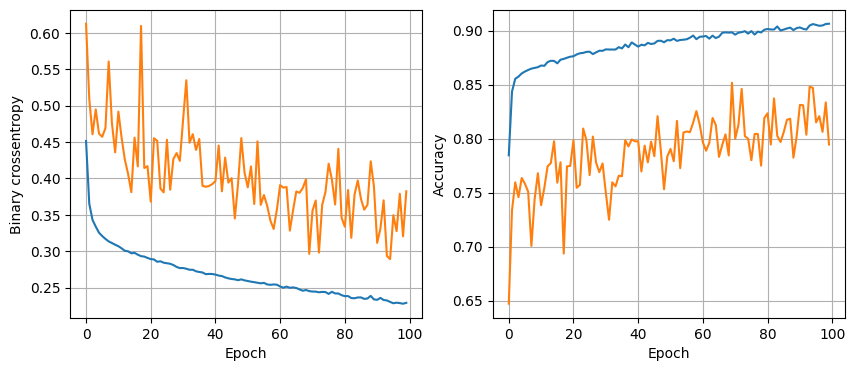

119/119 [==============================] - 0s 3ms/step - loss: 0.3367 - accuracy: 0.8691
64 nodes, dropout 0, lr 0.001, batch size 128


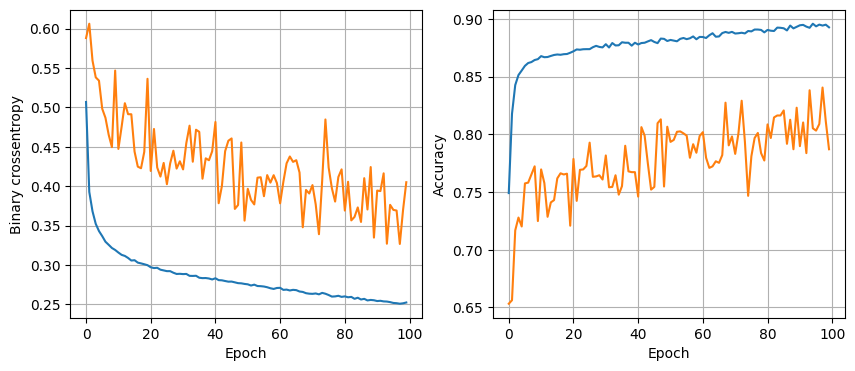

119/119 [==============================] - 0s 2ms/step - loss: 0.3209 - accuracy: 0.8717
64 nodes, dropout 0.2, lr 0.01, batch size 32


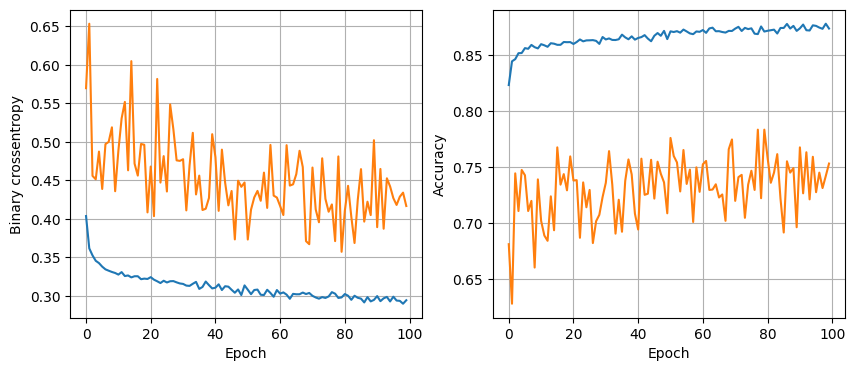

119/119 [==============================] - 0s 2ms/step - loss: 0.3224 - accuracy: 0.8699
64 nodes, dropout 0.2, lr 0.01, batch size 64


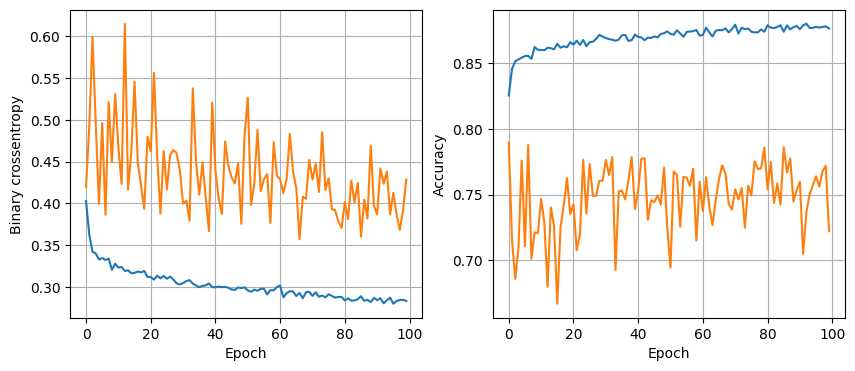

119/119 [==============================] - 0s 2ms/step - loss: 0.3247 - accuracy: 0.8701
64 nodes, dropout 0.2, lr 0.01, batch size 128


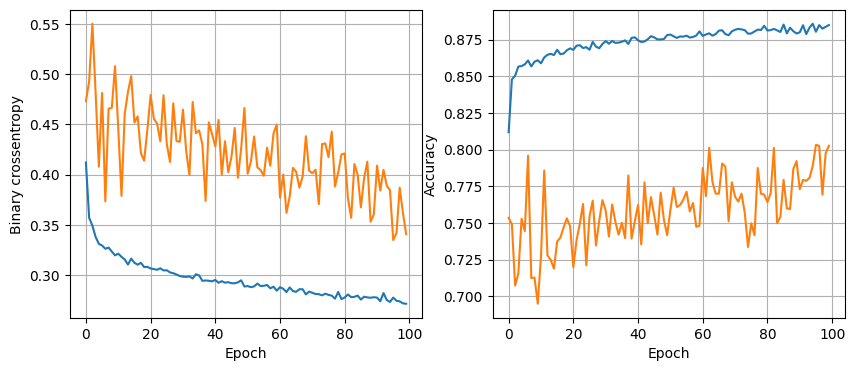

119/119 [==============================] - 0s 3ms/step - loss: 0.3127 - accuracy: 0.8796
64 nodes, dropout 0.2, lr 0.005, batch size 32


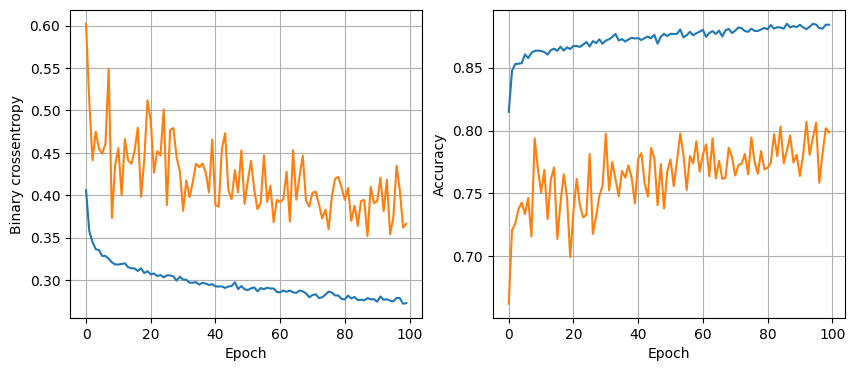

119/119 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.8754
64 nodes, dropout 0.2, lr 0.005, batch size 64


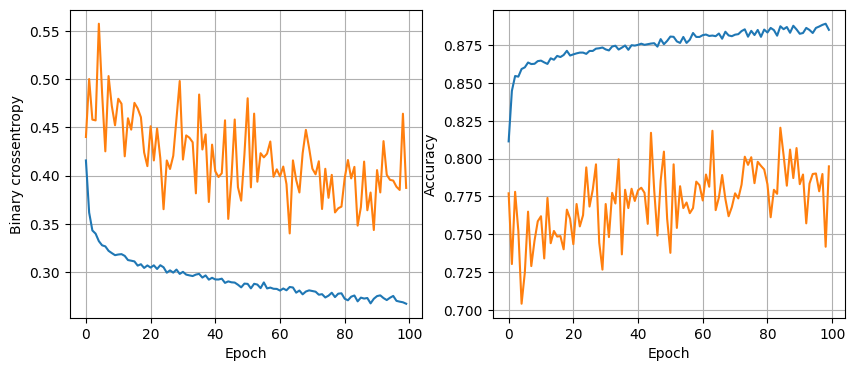

119/119 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.8783
64 nodes, dropout 0.2, lr 0.005, batch size 128


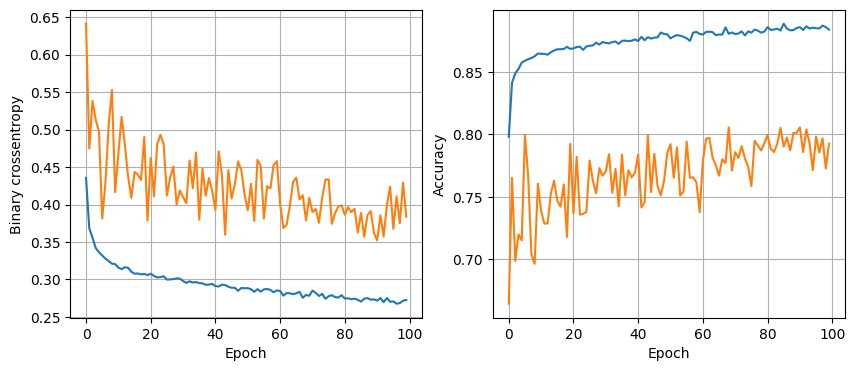

119/119 [==============================] - 0s 2ms/step - loss: 0.3007 - accuracy: 0.8799
64 nodes, dropout 0.2, lr 0.001, batch size 32


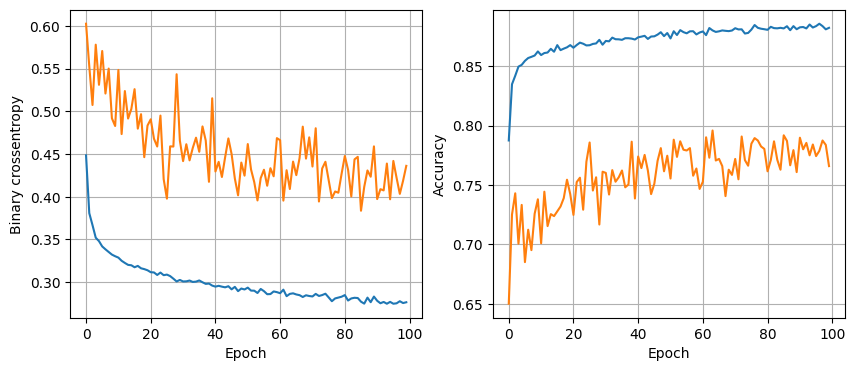

119/119 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.8754
64 nodes, dropout 0.2, lr 0.001, batch size 64


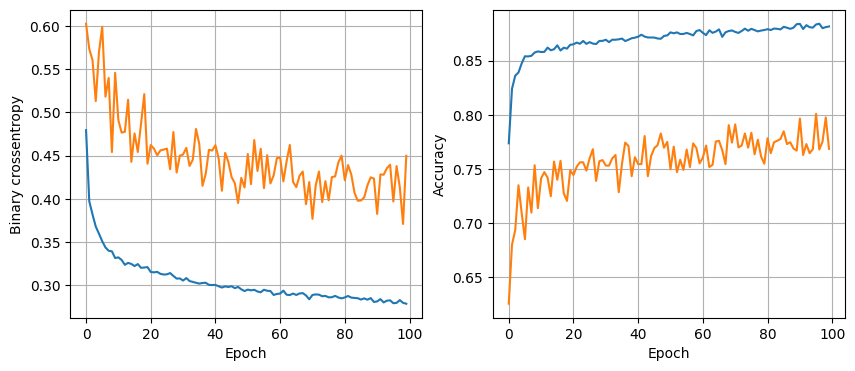

119/119 [==============================] - 0s 3ms/step - loss: 0.3076 - accuracy: 0.8783
64 nodes, dropout 0.2, lr 0.001, batch size 128


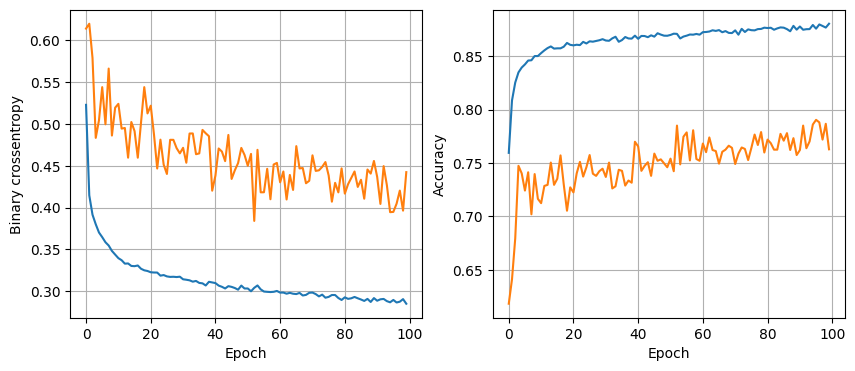

119/119 [==============================] - 0s 3ms/step - loss: 0.3057 - accuracy: 0.8783


In [20]:
# set different parameters for the grid search
num_nodes = [16, 32, 64]
dropout_probs = [0, 0.2]
lrs = [0.01, 0.005, 0.001]
batch_sizes = [32, 64, 128]

# set standard number of epochs
epochs = 100

# set variables to be overwritten during grid search
least_val_loss = float('inf')
least_loss_model = None

# iterate over different combination of metrics
for num_node in num_nodes:
    for dropout_prob in dropout_probs:
        for lr in lrs:
            for batch_size in batch_sizes:
              print(f"{num_node} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
              model, history = train_model(X_train, y_train, num_node, dropout_prob, lr, batch_size, epochs)
              plot_history(history)
              val_loss = model.evaluate(X_valid, y_valid)[0]
              # if the validation loss is ever less than the least validation loss,
              # we set the least validation loss equal to the validation loss and
              # the least loss model is set to the model that generated the validation loss
              if val_loss < least_val_loss:
                  least_val_loss = val_loss
                  least_loss_model = model

We see the validation loss decrease while the accuracy increases.

Using the results from the grid search above, we see that the highest accuracy and lowest loss combination, 0.8825 and 0.3005, respectively, is achieved using 32 nodes, a dropout rate of 0.2, a learning rate of 0.005, and a batch size of 32.We can use the `get_config()` method to confirm the model hyperparameters that were selected via the grid search process.

In [22]:
least_loss_model.get_config()

{'name': 'sequential_32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_99_input'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense_99',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 10),
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'registered_name': None,
   'build_config

Now, we want to take the least loss model and use it to predict x.

In [23]:
# we see here that there are some values that are close to 0
# and other values that are very close to 1
# this makes sense given that we have a sigmoid output layer
least_loss_model.predict(X_test)

119/119 [==============================] - 0s 3ms/step


array([[0.8899492 ],
       [0.8823943 ],
       [0.69581527],
       ...,
       [0.9875069 ],
       [0.92349666],
       [0.9979365 ]], dtype=float32)

In [25]:
# we can instead cast to create binary labels
# turn the cast labels into a one-dimensional column
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

y_pred
print(classification_report(y_test, y_pred))

119/119 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1380
           1       0.87      0.94      0.90      2424

    accuracy                           0.87      3804
   macro avg       0.87      0.85      0.86      3804
weighted avg       0.87      0.87      0.87      3804



We see that the precision on hadrons (class 0) increased relative to other supervised methods. These represent meaningful precision, recall, and F1-score measurements.